# Develop a Chatbot Using Python, NLTK, and TensorFlow

In [1]:
# Run this cell so you do not see GPU availibility errors from tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

### Task 1: Import the Required Libraries

In [2]:
import json
import random
import pickle

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import numpy as np
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM

import matplotlib.pyplot as plt


E0000 00:00:1751755908.924043     478 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751755908.932126     478 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751755909.061488     478 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751755909.061595     478 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751755909.061599     478 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751755909.061602     478 computation_placer.cc:177] computation placer already registered. Please check linka

### Task 2: Load the Data

In [3]:
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True) 
nltk.download('wordnet', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('omw-1.4', quiet=True)

with open('/usercode/intents.json') as data:
    intents = json.loads(data.read())


### Task 3: Tokenization

In [4]:
# Initialize necessary lists
words = []
classes = []
documents = []

# Iterate through intents 
for intent in intents['intents']:
    # Loop through each pattern in an intent
    for pattern in intent['patterns']:
        # Tokenize the pattern
        w = nltk.word_tokenize(pattern) 
        # Add tokens to the `words` list
        words.extend(w)
        # Store (tokenized words, intent tag)
        documents.append((w, intent['tag']))
        # Add unique intent tag to the list
        if intent['tag'] not in classes:
            classes.append(intent['tag'])


### Task 4: Lemmatization

In [5]:
#  Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()
# List for ignored characters & Stopwords
ignore_words = ['?', '!', '.', ',']
stop_words = set(stopwords.words('english'))  # Add stopwords for better preprocessing

# Lemmatize and remove stopwords
words = [lemmatizer.lemmatize(w.lower()) for w in words if w not in ignore_words and w.lower() not in stop_words]

# Remove duplicates & sort words and classes
words = sorted(set(words))
classes = sorted(set(classes))

# Save processed words
with open('/usercode/words.pkl', 'wb') as file:
    pickle.dump(words, file)

# Save processed classes
with open('/usercode/classes.pkl', 'wb') as file:
    pickle.dump(classes, file)


### Task 5: Create Data for Training

In [6]:
# Create Data for Training
training = []
output_empty = [0] * len(classes)

# Iterate through the documents list
for doc in documents:
    bag = []
    pattern_words = [lemmatizer.lemmatize(word.lower()) for word in doc[0]] # lemmatize and lowercase each sentence
    bag = [1 if w in pattern_words else 0 for w in words] # Creates a list (bag) where 1 indicates the presence of a word and 0 means it's absent.
    # Create One-Hot Encoded Labels
    output_row = list(output_empty)
    output_row[classes.index(doc[1])] = 1
    # Add data to the training set
    training.append([bag, output_row])

# Shuffle and convert data to NumPy arrays
random.shuffle(training)
training = np.array(training, dtype='object')

# Extract features (`X_train`) and labels (`y_train`)
X_train = list(training[:, 0])
y_train = list(training[:, 1])

# Convert data to TensorFlow Dataset
X_train = np.array(X_train)
y_train = np.array(y_train)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Convert data to TensorFlow dataset for training
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(1024).batch(32)


### Task 6: Design the Model

In [7]:
# Initialize the Model
model = Sequential([
    Dense(256, input_shape=(len(X_train[0]),), activation='relu'), # input layer and first hidden layer
    Dropout(0.3), # first dropout layer
    Dense(128, activation='relu'), # second hidden layer
    Dropout(0.3), # second dropout layer
    Dense(64, activation='relu'), # third hidden layer
    # Output layer
    Dense(len(y_train[0]), activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Task 7: Train and Save the Model

In [8]:
# Compile the Model
model.compile(
            loss='categorical_crossentropy',
            optimizer=Adam(learning_rate=0.001), 
            metrics=['accuracy'])

# Train the Model
history = model.fit(
                    train_data, 
                    epochs=200, verbose=1,
                    validation_data=(X_val, y_val))

# Save the Model
model.save('/usercode/trained_model.keras')


Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 248ms/step - accuracy: 0.1058 - loss: 2.5805 - val_accuracy: 0.0769 - val_loss: 2.5640
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1651 - loss: 2.5527 - val_accuracy: 0.0769 - val_loss: 2.5608
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1058 - loss: 2.5298 - val_accuracy: 0.0769 - val_loss: 2.5573
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1931 - loss: 2.5197 - val_accuracy: 0.0769 - val_loss: 2.5550
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3093 - loss: 2.4819 - val_accuracy: 0.0000e+00 - val_loss: 2.5562
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3710 - loss: 2.4558 - val_accuracy: 0.0000e+00 - val_loss: 2.5556
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3373 - loss: 2.4308 - val_accuracy: 0.0000e+00 - val_loss: 2.5551
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3325 - loss: 2.4007 - val_accuracy: 0.000

### Task 8: Print the Training Curves

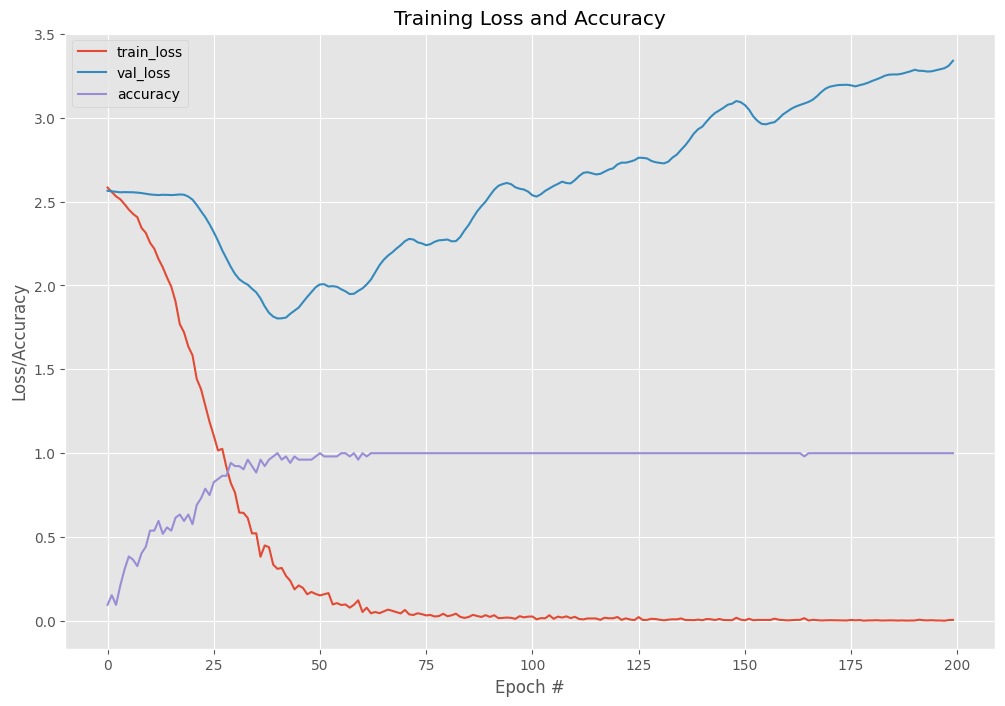

In [9]:
# Print the training curves
plt.rcParams["figure.figsize"] = (12, 8)
epochs = np.arange(0, 200)
plt.style.use("ggplot")
plt.figure()
plt.plot(epochs, history.history["loss"], label="train_loss")
plt.plot(epochs, history.history["val_loss"], label="val_loss")
plt.plot(epochs, history.history["accuracy"], label="accuracy")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()